# 멀티 에이전트 네트워크
단일 에이전트는 일반적으로 하나의 도메인 내에서 몇 가지 도구만을 사용해도 효과적으로 작동할 수 있습니다. 하지만 GPT-4처럼 강력한 모델을 사용하더라도 많은 도구를 동시에 다루는 데에는 한계가 있을 수 있습니다.

복잡한 작업을 해결하는 한 가지 접근 방식은 ‘분할 정복(divide-and-conquer)’ 전략입니다. 이는 각 작업이나 도메인에 특화된 에이전트를 만들고, 해당 작업을 적절한 ‘전문가’에게 전달하는 방식입니다. 이러한 구조는 [multi-agent network](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network) 아키텍처의 한 예입니다.

이 노트북에서는 Wu 외 연구진의 논문 [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155)에서 영감을 받아, LangGraph를 사용해 멀티 에이전트 네트워크를 구현하는 방법을 소개합니다.

최종적으로 생성되는 그래프는 다음과 같은 형태를 가지게 됩니다:

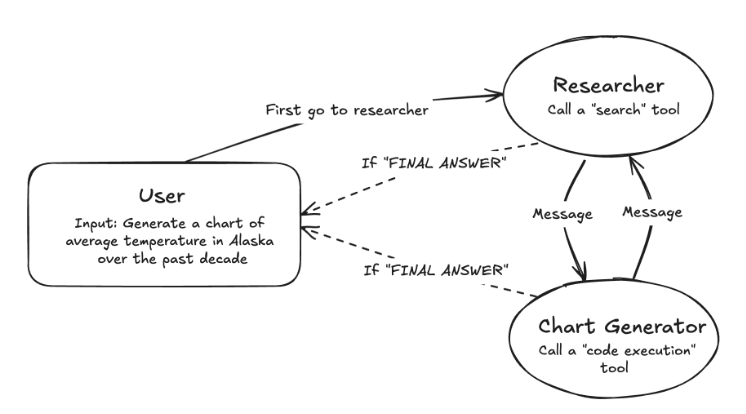

⚠️ 시작하기 전에 간단한 안내: 이 노트북을 포함한 멀티 에이전트 관련 노트북들은 특정 설계 패턴을 LangGraph로 구현하는 방법을 보여주기 위한 것입니다. 만약 이 패턴이 여러분의 사용 목적에 적합하다면, 문서의 다른 기본 패턴들과 함께 사용하는 것을 권장합니다. 그래야 최상의 성능을 낼 수 있습니다.

## 도구 정의하기
앞으로 에이전트들이 사용할 도구들도 함께 정의해보겠습니다.

In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [ ]:
!pip install langchain_ollama
from langchain_ollama import ChatOllama

local_llm = 'qwen2.5:14b'
llm = ChatOllama(
    model=local_llm,
    temperature=0,
)

In [ ]:
!pip install langchain_tavily langchain_experimental
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# 웹 크롤링을 위한 Tool 정의
tavily_tool = TavilySearch(max_results=5)

# 파이썬 코드를 실행할 수 있는 Tool 정의
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## 그래프 생성하기
도구와 보조 함수들을 정의했으니, 이제는 각 에이전트를 생성하고 이들이 LangGraph를 통해 서로 소통하는 방식을 지정하겠습니다.

### 에이전트 노드 정의하기
이제 각 노드를 정의해야 합니다.

우선, 각 에이전트에 적합한 **시스템 프롬프트(system prompt)**를 생성하는 유틸리티 함수를 만들어보겠습니다.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )


"당신은 다른 AI 어시스턴트들과 협업하는 유용한 AI 어시스턴트입니다."

"주어진 도구들을 활용하여 질문에 대한 답변을 향해 나아가세요."

"만약 완벽한 답변을 할 수 없다면 괜찮습니다. 다른 도구를 가진 어시스턴트가 당신이 멈춘 지점부터 도와줄 것입니다."

"가능한 부분까지 실행하여 최대한 진행하세요."

"당신 또는 다른 어시스턴트가 최종 답변이나 결과물을 도출한 경우,"

"응답 앞에 FINAL ANSWER라는 문구를 붙여 팀이 멈춰도 된다는 것을 알 수 있게 하세요."

In [ ]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


# 마지막 메시지 내용을 확인하여 다음 노드 결정
def get_next_node(last_message: BaseMessage, goto: str):
    # 메시지에 "FINAL ANSWER"가 포함되어 있다면 그래프 종료
    if "FINAL ANSWER" in last_message.content:
        return END
    # 그렇지 않으면 지정된 다음 노드로 이동
    return goto


# -------------------
# Research Agent 정의
# -------------------

# 리서치(조사) 전용 에이전트 생성
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],  # 조사용 도구 설정 (예: 검색 API)
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

# 리서치 노드 정의
def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    # 현재까지의 메시지 상태(state)를 바탕으로 조사 수행
    result = research_agent.invoke(state)

    # 마지막 메시지 분석 후 다음 이동 경로 결정 (chart_generator 또는 END)
    goto = get_next_node(result["messages"][-1], "chart_generator")

    # 마지막 메시지를 사람(HumanMessage) 형태로 래핑
    # 일부 LLM 제공자들은 AI 메시지가 마지막에 오는 것을 허용하지 않음
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )

    # 메시지 업데이트 및 다음 노드 정보 반환
    return Command(
        update={
            "messages": result["messages"],  # 메시지 히스토리를 공유
        },
        goto=goto,
    )
 
# ----------------------------
# Chart Generator Agent 정의
# ----------------------------

# ⚠️ 이 에이전트는 파이썬 코드를 실행하므로 샌드박싱 환경이 아니면 보안에 위험할 수 있음
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],  # 차트 생성용 Python 실행 도구
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

# 차트 생성 노드 정의
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    # 현재 메시지 상태를 바탕으로 차트 생성 수행
    result = chart_agent.invoke(state)

    # 마지막 메시지에 따라 다음 이동 경로 결정 (researcher 또는 END)
    goto = get_next_node(result["messages"][-1], "researcher")

    # 마지막 메시지를 사람 형태로 래핑
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )

    # 메시지 업데이트 및 다음 노드 정보 반환
    return Command(
        update={
            "messages": result["messages"],  # 메시지 히스토리 공유
        },
        goto=goto,
    )
    


### 그래프 정의하기

이제 모든 요소를 하나로 모아 그래프를 정의할 수 있습니다!

In [ ]:
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 호출하기 (Invoke)
그래프를 모두 생성했으니, 이제 호출하여 실행해볼 수 있습니다!

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

events = graph.stream(
    {
        "messages": [
            (
                "user",
                "대한민국의 2018년부터 2024년까지의 전기자동차 판매량 데이터를 찾아줘, "
                "그리고 수집한 데이터에 대한 그래프를 그려줘. "
                "그래프를 다 그렸다면 종료해줘.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
for s in events:
    print(s)
    print("----")

# 실습문제: 프롬프트를 수정하여 미국의 가전 제품 시장 규모 그래프 그리기

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

events = graph.stream(
    {
        "messages": [
            (
                "user",
                "~데이터를 찾아줘, "
                "그리고 수집한 데이터에 대한 그래프를 그려줘. "
                "그래프를 다 그렸다면 종료해줘.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
for s in events:
    print(s)
    print("----")